<a href="https://colab.research.google.com/github/littlejacinthe/Audio_NeuralStyle/blob/master/Wav_STN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

#from __future__ import print_function

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats

import torchvision.transforms as transforms
import torchvision.models as models
import pickle

import copy
import os
import math
import soundfile as sf

In [2]:
use_cuda = torch.cuda.is_available() #use GPU if available
print('GPU available =',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

GPU available = True


In [3]:
# set filenames
STYLE_FILENAME = "classical_03.wav" #input filename
savename_style = 'transferred' #output filename
CONTENT_FILENAME = "jazz_05.wav" #input filename, None if doing texture synthesis
runs = 1 # no. of separate outputs (to test consistency), 1 if only want single output

In [4]:
display(Audio(STYLE_FILENAME))
display(Audio(CONTENT_FILENAME))

In [5]:
def read_audio_spectum(filename):
    x, fs = librosa.load(filename) #x=audiodata, fs=samplerate
    print("audio loaded")
    return x, fs

def findMinMax(wav):
    return int(math.floor(np.amin(wav))),int(math.ceil(np.amax(wav)))

def scale(wav,dataMin,dataMax,scaleMin,scaleMax):
    """scales input numpy array from [dataMin,dataMax] -> [scaleMin,scaleMax]"""    
    shift = (scaleMax-scaleMin) / (dataMax-dataMin)
    scaled_values = shift * (wav-dataMin) + scaleMin
    print("Using [{0},{1}] -> [{2},{3}] for scale conversion".format(dataMin,dataMax,scaleMin,scaleMax))
    return scaled_values

def invscale(wav,dataMin,dataMax,scaleMin,scaleMax):
    """scales input numpy array from [scaleMin,scaleMax] -> [dataMin,dataMax]"""
    shift = (dataMax-dataMin) / (scaleMax-scaleMin)
    scaled_values = shift * (wav-scaleMin) + dataMin
    print("Using [{0},{1}] -> [{2},{3}] for scale conversion".format(scaleMin,scaleMax,dataMin,dataMax))
    return scaled_values

audio loaded
(661794,)
wav range before scaling -0.30044556 0.30218506
Using [-1,1] -> [0,1] for scale conversion
wav range after [0,1] scaling: 0.34977722 0.6510925
wav shape  (1, 661794)


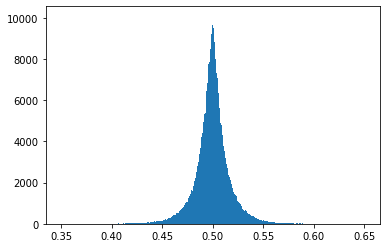

 Input shape: torch.Size([1, 1, 661794])


In [6]:
a_style, fs = read_audio_spectum(STYLE_FILENAME)
print(a_style.shape)
print("wav range before scaling",np.amin(a_style),np.amax(a_style))

a_min,a_max = findMinMax(a_style)
a_style = scale(a_style,a_min,a_max,0,1)
print("wav range after [0,1] scaling:",np.amin(a_style),np.amax(a_style))

a_style = np.expand_dims(a_style, 0) 
print("wav shape ", a_style.shape) 

#plt.ion()
fig = plt.figure()
#plt.title('Style histogram')
ax = fig.add_subplot(111)
n,b,_ = ax.hist(a_style.flatten(),bins='auto')
plt.show()
fig.savefig(savename_style+'_styleinput'+'_hist.png',bbox_inches='tight')

N_SAMPLES = a_style.shape[1] #time bins

a_style = np.ascontiguousarray(a_style[None,:,:]) #[batch,channels,freq]
a_style = torch.from_numpy(a_style) #pytorch:[batch,channels(1),freq]

style_wav = Variable(a_style).type(dtype) #convert to pytorch variable
print(" Input shape:",style_wav.data.shape) #check shape is correct

audio loaded
(661794,)
wav range before scaling -0.74160767 0.7677002
Using [-1,1] -> [0,1] for scale conversion
wav range after [0,1] scaling: 0.12919617 0.8838501
wav shape  (1, 661794)


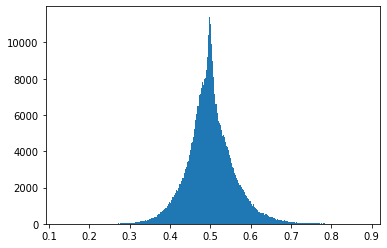

 Input shape: torch.Size([1, 1, 661794])


In [7]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
print(a_content.shape)
print("wav range before scaling",np.amin(a_content),np.amax(a_content))

a_min,a_max = findMinMax(a_content)
a_content = scale(a_content,a_min,a_max,0,1)
print("wav range after [0,1] scaling:",np.amin(a_content),np.amax(a_content))

a_content = np.expand_dims(a_content, 0) 
print("wav shape ", a_content.shape) 

#plt.ion()
fig = plt.figure()
#plt.title('Style histogram')
ax = fig.add_subplot(111)
n,b,_ = ax.hist(a_content.flatten(),bins='auto')
plt.show()
fig.savefig(savename_style+'_styleinput'+'_hist.png',bbox_inches='tight')


a_content = np.ascontiguousarray(a_content[None,:,:]) #[batch,channels,freq]
a_content = torch.from_numpy(a_content) #pytorch:[batch,channels(1),freq]

content_wav = Variable(a_content).type(dtype) #convert to pytorch variable
print(" Input shape:",content_wav.data.shape) #check shape is correct

In [18]:
# linear interpolation

def transform(input):
  # grab shape
  B, W, C = input.shape # Width is then time and C channels

  # initialize M to identity transform
  #M = np.array([1., 0.])

  # translation
  #M = np.array([[1., 0.5]])

  # rotation
  #M = np.array([[0.906, -0.422]])

  #scaling
  #M = np.array([[0.5, 0.]])

  #affine
  M = np.array([[0.5, 0.08]])

  # repeat num_batch times
  M = np.resize(M, (B, 1, 2))

  # create normalized 2D grid
  x = torch.linspace(-1, 1, W) # Return evenly spaced numbers over a specified interval.

  x_t = torch.meshgrid(x) # Return coordinate matrices from coordinate vectors.
  x_t = torch.Tensor(x_t)

  ones = torch.ones(np.prod(x_t.shape))

  sampling_grid = torch.vstack([x_t.flatten(), ones])

  # repeat grid num_batch times
  sampling_grid = torch.resize_(sampling_grid, (B, 2, W))
  sampling_grid.shape

  # transform the sampling grid i.e. batch multiply
  batch_grids = np.matmul(M, sampling_grid) # Matrix product of two arrays.
  # batch grid has shape (num_batch, 2, H*W)

  # reshape to (num_batch, height, width, 2)
  batch_grids = batch_grids.reshape(B, 1, W)
  batch_grids = np.moveaxis(batch_grids, 1, -1)

  x_s = batch_grids[:, :, 0:1].squeeze()

  # rescale x and y to [0, W/H]
  x = ((x_s + 1.) * W) * 0.5

  # grab 4 nearest corner points for each (x_i, y_i)
  x0 = np.floor(x).astype(np.int64)
  x1 = x0 + 1

  # make sure it's inside img range [0, H] or [0, W]
  x0 = np.clip(x0, 0, W-1)
  x1 = np.clip(x1, 0, W-1)

  # look up pixel values at corner coords
  Ia = input[np.arange(B)[:, None], x1]
  Ib = input[np.arange(B)[:, None], x0]

  # calculate deltas
  wa = (x1-x) * (x1-x0)
  wb = (x-x0) * (x1-x0)

  # add dimension for addition
  wa = np.expand_dims(wa, axis=2)
  wb = np.expand_dims(wb, axis=2)

  wIa = wa*Ia

  # compute output
  out = wa*Ia + wb*Ib
  out1 = np.reshape(out1, [C, W])
  plt.figure()
  librosa.display.waveplot(out1, sr=fs)
  sf.write('inter_out.wav', out1, fs)
  return out1


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv1d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout1d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=7),
            nn.MaxPool1d(2, stride=2),
            nn.ReLU(True),
            nn.Conv1d(8, 10, kernel_size=5),
            nn.MaxPool1d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(1654450, 32),
            nn.ReLU(True),
            nn.Linear(32, 1 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([0.5, 0.08], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 1654450)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 1, 2)

        x = transform(xs)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().cuda()

In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    data, target = content_wav.cuda(), style_wav.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        data, target = style_wav.cuda(), content_wav.cuda()
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item()
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/%)\n'.format(test_loss, correct))

In [17]:
def convert_np(inp):
    """Convert a Tensor to wav."""
    inp = inp.numpy()
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def wav_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = content_wav.cuda()

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        out_wav = convert_np(transformed_input_tensor)

        sf.write(savename_style + '.wav', out_wav, fs)

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
wav_stn()
OUTPUT_FILENAME = savename_style + '.wav'
display(Audio(OUTPUT_FILENAME))

NameError: ignored